In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import torchvision.transforms.functional as TF
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import os
from google.colab import userdata

In [ ]:
from google.colab import userdata
import os

# Colab Secrets에서 KAGGLE_USERNAME과 KAGGLE_KEY를 가져와 환경 변수로 설정합니다.
try:
    os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
    os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
except:
    print("User info has not been set")

    # Kaggle 데이터셋 다운로드
print("User info connected successfully!!!")
print("Kaggle credentials loaded successfully. Downloading dataset...")
!kaggle datasets download -d balraj98/berkeley-segmentation-dataset-500-bsds500

    # 다운로드한 파일 압축 해제
!unzip -q berkeley-segmentation-dataset-500-bsds500.zip -d ./bsds500

print("Dataset Download and Unzip Complete")

User info connected successfully!!!
Kaggle credentials loaded successfully. Downloading dataset...
Dataset URL: https://www.kaggle.com/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500
License(s): other
  0% 0.00/56.0M [00:00<?, ?B/s]
100% 56.0M/56.0M [00:00<00:00, 1.73GB/s]
Dataset Download and Unzip Complete


In [ ]:
head_path = "/content/bsds500"
ground_truth_path = os.path.join(head_path, "ground_truth")
# 해당 폴더 내의 파일들은 Segmentation 혹은 Edge Detection, Rand Error / Warping Error 평가 시에 사용되는 데이터로,
# 본 파일에서 진행 할 Denoising에서는 사용하지 않는다.

images_path = os.path.join(head_path, "images")
files = os.listdir(head_path)
print(files)
print(os.listdir(ground_truth_path))
print(os.listdir(images_path))

num_test_img = len(os.listdir(os.path.join(images_path, "test")))
num_train_img = len(os.listdir(os.path.join(images_path, "train")))
num_val_img = len(os.listdir(os.path.join(images_path, "val")))

print(f"\nTest 이미지 개수 : {num_test_img}")
print(f"Train 이미지 개수 : {num_train_img}")
print(f"Valid 이미지 개수 : {num_val_img}")

['ground_truth', 'images']
['test', 'val', 'train']
['test', 'val', 'train']

Test 이미지 개수 : 201
Train 이미지 개수 : 201
Valid 이미지 개수 : 101


In [ ]:
train_path = os.path.join(images_path, "train")
val_path = os.path.join(images_path, "val")
test_path = os.path.join(images_path, "test")

{(481, 321)} {'RGB'}


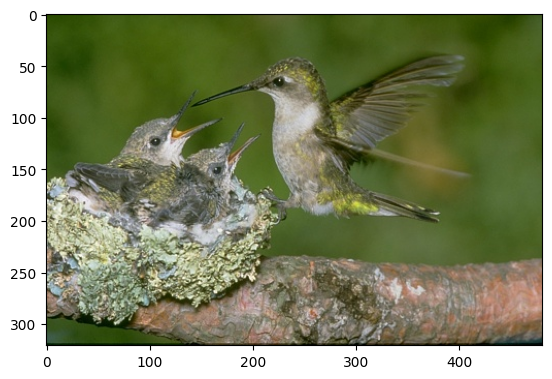

In [ ]:
image_files = os.listdir(train_path)
image_files = [f for f in image_files if f.lower().endswith(".jpg")]

first_image_filename = image_files[0]
first_image_path = os.path.join(train_path, first_image_filename)

plt.imshow(Image.open(first_image_path))
print({Image.open(first_image_path).size}, {Image.open(first_image_path).mode})
plt.show()

In [ ]:
train_transform = transforms.Compose([
       transforms.RandomChoice([
           transforms.RandomRotation((0, 0)),
           transforms.RandomRotation((90, 90)),
           transforms.RandomRotation((180, 180)),
           transforms.RandomRotation((270, 270))
      ]),
      transforms.RandomCrop(40),
      transforms.RandomVerticalFlip(p=0.5),
      transforms.RandomHorizontalFlip(p=0.5),

      transforms.ToTensor()
])

val_transform = transforms.Compose([
      transforms.CenterCrop(40),
      transforms.ToTensor()
])

In [ ]:
# class CustomDataset(Dataset):
#     def __init__(self, image_path, mode, noise_factor, transform=None):
#         self.image_path = image_path
#         self.mode = mode
#         self.noise_factor = noise_factor
#         self.transform = transform

#         self.image_files = sorted(os.listdir(self.image_path))
#         self.image_files = [f for f in self.image_files if f.lower().endswith(".jpg")]

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         clean_image = Image.open(os.path.join(self.image_path, self.image_files[idx])).convert("RGB")

#         if self.transform:
#             clean_image = self.transform(clean_image)

#             sigma = self.noise_factor / 255.0
#             noise = torch.randn_like(clean_image) * sigma
#             noisy_image = clean_image + noise
#             noisy_image = torch.clamp(noisy_image, 0.0, 1.0)

#         return noisy_image, clean_image

## 랜덤 노이즈 전용 CustomDataset

In [ ]:
import random
class CustomDataset(Dataset):
    def __init__(self, image_path, mode, transform=None):
        self.image_path = image_path
        self.mode = mode
        #self.noise_factor = noise_factor
        self.transform = transform

        self.image_files = sorted(os.listdir(self.image_path))
        self.image_files = [f for f in self.image_files if f.lower().endswith(".jpg")]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        clean_image = Image.open(os.path.join(self.image_path, self.image_files[idx])).convert("RGB")

        if self.transform:
            clean_image = self.transform(clean_image)

        random_noise = random.uniform(5, 50)
        sigma = random_noise / 255.0

        noise_choice = random.random()
        noisy_image = clean_image.clone()

        if noise_choice < 0.33:
            # Gaussian Noise
            noise = torch.randn_like(clean_image) * sigma
            noisy_image = clean_image + noise
            noise_type = 'Gaussian'

        elif 0.33 <= noise_choice < 0.66:
            # Poisson Noise
            scale = 1.0 / (sigma+1e-6)
            noisy_image = torch.poisson(clean_image*scale) / scale
            noise_type = 'Poisson'

        else:
            noise = torch.randn_like(clean_image) * sigma
            noisy_image = clean_image + (clean_image * noise)
            noise_type = "Speckle"

        noisy_image = torch.clamp(noisy_image, 0.0, 1.0)

        return noisy_image, clean_image, noise_type

In [ ]:
# train_dataset = CustomDataset(train_path, mode='train', noise_factor=50, transform = train_transform)
# val_dataset = CustomDataset(val_path, mode='val', noise_factor=50, transform=val_transform)
# test_dataset = CustomDataset(test_path, mode='test', noise_factor=50, transform=val_transform)

In [ ]:
train_dataset = CustomDataset(train_path, mode='train', transform = train_transform)
val_dataset = CustomDataset(val_path, mode='val', transform=val_transform)
test_dataset = CustomDataset(test_path, mode='test', transform=val_transform)

In [ ]:
train_loader = DataLoader(batch_size=32, shuffle=True, dataset=train_dataset, num_workers=2)
val_loader = DataLoader(batch_size=32, shuffle=False, dataset=val_dataset, num_workers=0)
test_loader = DataLoader(batch_size=32, shuffle=False, dataset=test_dataset, num_workers=0)

In [ ]:
# Noise distribution of each batch.
from collections import Counter

dataiter = iter(train_loader)
_, _, noise_types = next(dataiter)

print(Counter(noise_types))

Counter({'Gaussian': 13, 'Speckle': 11, 'Poisson': 8})


Min/Max of Clean: 0.0 1.0
('Poisson', 'Speckle', 'Gaussian', 'Poisson', 'Gaussian', 'Speckle', 'Poisson', 'Gaussian', 'Poisson', 'Poisson', 'Gaussian', 'Poisson', 'Gaussian', 'Poisson', 'Poisson', 'Poisson', 'Poisson', 'Gaussian', 'Speckle', 'Gaussian', 'Poisson', 'Gaussian', 'Poisson', 'Gaussian', 'Gaussian', 'Poisson', 'Speckle', 'Gaussian', 'Poisson', 'Speckle', 'Gaussian', 'Poisson')


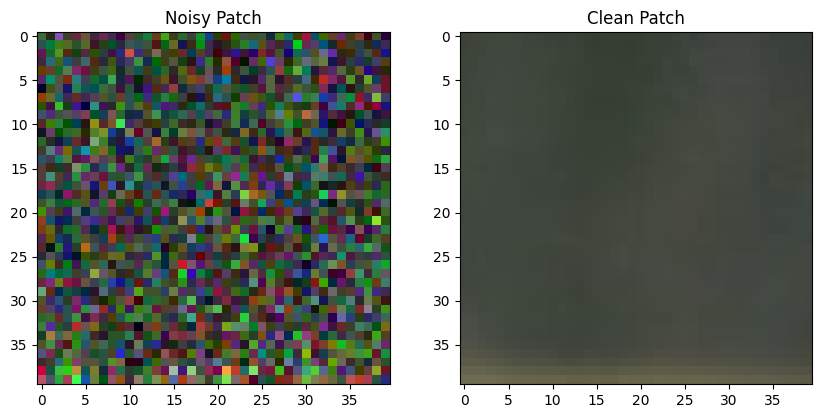

In [88]:
dataiter = iter(train_loader)
noisy_image, clean_image, noise_types = next(dataiter)

print("Min/Max of Clean:", clean_image.min().item(), clean_image.max().item())
print(noise_types)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Noisy Patch")
plt.imshow(noisy_image[0].permute(1, 2, 0).cpu().numpy())
plt.subplot(1, 2, 2)
plt.title("Clean Patch")
plt.imshow(clean_image[0].permute(1, 2, 0).cpu().numpy())
plt.show()

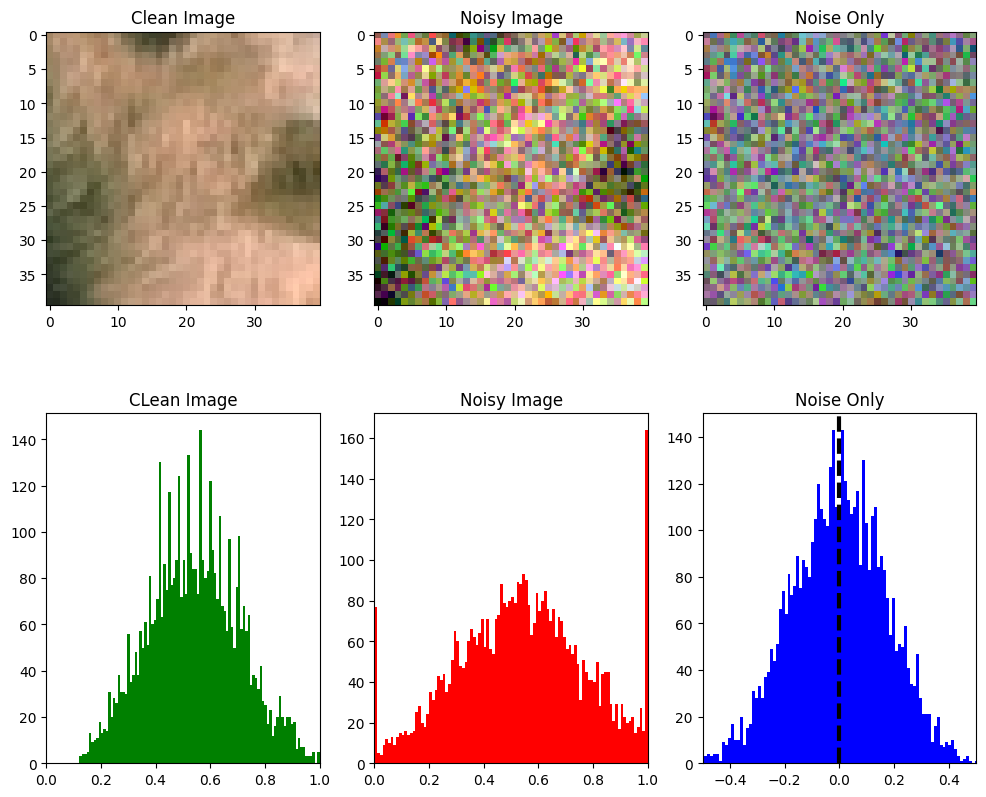

In [89]:
def analyze(dataset, index=0):
    noisy_tensor, clean_tensor, noise_types = dataset[index]

    noise_only_tensor = noisy_tensor - clean_tensor

    noise_flat = noise_only_tensor.flatten().numpy()
    clean_flat = clean_tensor.flatten().numpy()
    noisy_flat = noisy_tensor.flatten().numpy()

    plt.figure(figsize=(12, 10))

    plt.subplot(231)
    plt.imshow(clean_tensor.permute(1, 2, 0))
    plt.title("Clean Image")

    plt.subplot(232)
    plt.imshow(noisy_tensor.permute(1, 2, 0))
    plt.title("Noisy Image")

    plt.subplot(233)
    #plt.imshow(noise_only_tensor.permute(1, 2, 0))
    vis_noise = noise_only_tensor.permute(1, 2, 0).numpy()
    vis_noise = (vis_noise - np.min(vis_noise)) / (np.max(vis_noise) - np.min(vis_noise))
    plt.imshow(vis_noise)
    plt.title("Noise Only")

    plt.subplot(234)
    plt.hist(clean_flat, bins=100, color='green')
    plt.title("CLean Image")
    plt.xlim(0, 1)

    plt.subplot(235)
    plt.hist(noisy_flat, bins=100, color='red')
    plt.title("Noisy Image")
    plt.xlim(0, 1)

    plt.subplot(236)
    plt.hist(noise_flat, bins=100, color='blue')
    plt.title("Noise Only")
    #sigma_scale = dataset.noise_factor / 255.0
    #plt.xlim(-3 * sigma_scale, 3 * sigma_scale)
    plt.xlim(-0.5, 0.5)
    plt.axvline(0, color='k', linestyle='dashed', linewidth=3)

    plt.show()
analyze(train_dataset, 0)

In [74]:
class CDnCNN(nn.Module):  # DnCNN of colored image
    def __init__(self, n_channels=3, depth=17):
        super().__init__()

        # Stem
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, bias=True),
            nn.ReLU(inplace=True)
        )

        # Body
        layers=[]
        for _ in range(depth - 2):
            layers.append(nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(64))
            layers.append(nn.ReLU(inplace=True))
        self.body = nn.Sequential(*layers)

        # Head
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, padding=1, bias=True),
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.body(out)
        pred_noise = self.layer2(out)

        return pred_noise

In [75]:
# def weights_init_kaiming(m):

## Loss Function Changed
- In the case ofo blindn noise, L1 Loss might be better to preserve edge in complicaate noise situation rather than MSE(L2) Loss which square the gap of pixel value.

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CDnCNN().to(device)

n_epochs = 500

optimizer = optim.Adam(model.parameters(), lr = 0.001)
#criterion = nn.MSELoss(reduction='mean')
criterion = nn.L1Loss(reduction='mean')

In [77]:
INF = 1000
def calculate_PSNR(image1, image2):
    mse = torch.mean((image1 - image2) ** 2)
    if mse == 0:
        return INF
    else:
        return 10 * torch.log10(1.0/mse)

In [78]:
def train_model(model, train_loader, optimizer, criterion, device, epoch):
    model.train()

    loss_repo = 0.0
    psnr_repo = 0.0

    for inputs, targets, _ in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        #loss = criterion(outputs, targets)
        noise = inputs - targets
        loss = criterion(outputs, noise)
        denoised = inputs - outputs


        loss.backward()
        optimizer.step()

        denoised_img = inputs - outputs
        loss_repo += loss.item()
        psnr_repo += calculate_PSNR(denoised_img, targets).item()

    epoch_loss = loss_repo / len(train_loader)
    epoch_psnr = psnr_repo / len(train_loader)
    print(f"\nEpoch {epoch} Train - Loss : {epoch_loss:.6f}, PSNR : {epoch_psnr:.2f} dB")
    return epoch_loss, epoch_psnr

In [79]:
def val_model(model, val_loader, criterion, device, epoch):
    model.eval()

    loss_repo_val = 0.0
    psnr_repo_val = 0.0

    with torch.no_grad():
        for inputs, targets, _ in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            noise = inputs - targets
            loss = criterion(outputs, noise)
            #loss = criterion(outputs, targets)


            denoised_img = inputs - outputs
            loss_repo_val += loss.item()
            psnr_repo_val += calculate_PSNR(denoised_img, targets).item()
    val_avg_loss = loss_repo_val / len(val_loader)
    val_avg_psnr = psnr_repo_val / len(val_loader)

    print(f"Epoch {epoch} Valid - Loss : {val_avg_loss:.6f}, PSNR : {val_avg_psnr:2f} dB")
    return val_avg_loss, val_avg_psnr

In [80]:
def test_model(model, test_loader, criterion, deveice, epoch):
    model.eval()

    test_loss = 0.0
    test_psnr = 0.0

    with torch.no_grad():
        for inputs, targets, _ in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            noise = inputs - targets
            loss = criterion(outputs, noise)
            #loss = criterion(outputs, targets)
            denoised_img = inputs - outputs

            test_loss+=loss.item()
            test_psnr+=calculate_PSNR(denoised_img, targets).item()

    avg_loss = test_loss / len(test_loader)
    avg_psnr = test_psnr / len(test_loader)

    print(f"Epoch {epoch} Test - Loss : {avg_loss:.6f}, PSNR : {avg_psnr:.2f} dB")
    return avg_loss, avg_psnr

In [91]:
best_psnr = 0.0
best_model_wts = None

train_loss = []
train_psnr = []
val_psnr_hist = []

for epoch in range(n_epochs):
    loss, psnr = train_model(model, train_loader, optimizer, criterion, device, epoch+1)
    train_loss.append(loss)
    train_psnr.append(psnr)

    val_loss_epoch, val_psnr_epoch = val_model(model, val_loader, criterion, device, epoch+1)
    val_psnr_hist.append(val_psnr_epoch)

    if val_psnr_epoch > best_psnr:
        best_psnr = val_psnr_epoch
        best_model_wts = model.state_dict()

    current_lr = optimizer.param_groups[0]['lr']
    print(f"Current Learning Rate : {current_lr}")
model.load_state_dict(best_model_wts)



Epoch 1 Train - Loss : 0.177066, PSNR : 11.47 dB
Epoch 1 Valid - Loss : 0.116962, PSNR : 16.091291 dB
Current Learning Rate : 0.001

Epoch 2 Train - Loss : 0.081883, PSNR : 17.65 dB
Epoch 2 Valid - Loss : 0.090256, PSNR : 17.540334 dB
Current Learning Rate : 0.001

Epoch 3 Train - Loss : 0.085490, PSNR : 17.59 dB
Epoch 3 Valid - Loss : 0.083926, PSNR : 18.335108 dB
Current Learning Rate : 0.001

Epoch 4 Train - Loss : 0.085190, PSNR : 17.61 dB
Epoch 4 Valid - Loss : 0.112825, PSNR : 14.389531 dB
Current Learning Rate : 0.001

Epoch 5 Train - Loss : 0.076497, PSNR : 18.20 dB
Epoch 5 Valid - Loss : 0.106215, PSNR : 15.069944 dB
Current Learning Rate : 0.001

Epoch 6 Train - Loss : 0.080357, PSNR : 17.92 dB
Epoch 6 Valid - Loss : 0.106362, PSNR : 16.211674 dB
Current Learning Rate : 0.001

Epoch 7 Train - Loss : 0.077848, PSNR : 18.27 dB
Epoch 7 Valid - Loss : 0.087370, PSNR : 17.035827 dB
Current Learning Rate : 0.001

Epoch 8 Train - Loss : 0.076823, PSNR : 18.43 dB
Epoch 8 Valid - Los

<All keys matched successfully>

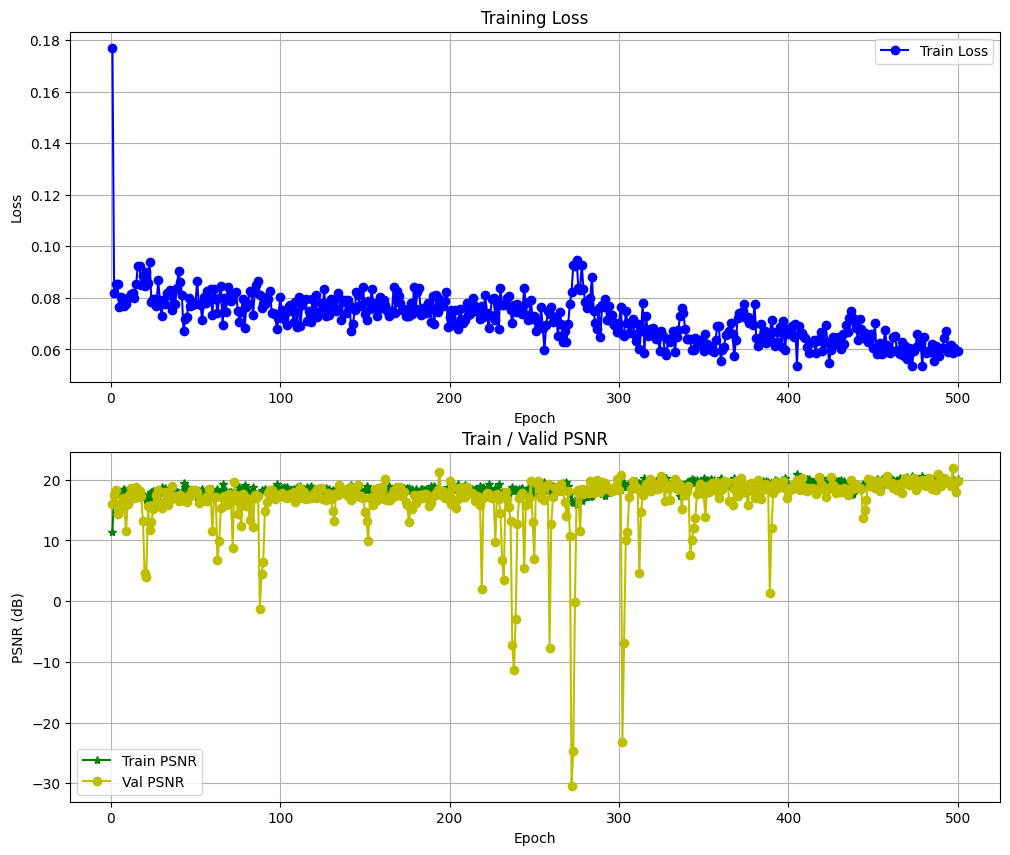

In [92]:
plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(range(1, n_epochs+1), train_loss, label='Train Loss', color='blue', marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.subplot(212)
plt.plot(range(1, n_epochs+1), train_psnr, label='Train PSNR', color='green', marker='*')
plt.plot(range(1, n_epochs+1), val_psnr_hist, label='Val PSNR', color='y', marker='o')
plt.title("Train / Valid PSNR")
plt.xlabel("Epoch")
plt.ylabel("PSNR (dB)")
plt.grid(True)
plt.legend()

In [93]:
def print_denoised(model, val_loader, num_samples=3):
    model.eval()

    data_iter = iter(val_loader)
    plt.figure(figsize=(15, 5 * num_samples))
    for i in range(num_samples):
        try:
            inputs, targets = next(data_iter)
        except:
            break
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            denoised_img = inputs - outputs
            denoised_img = torch.clamp(denoised_img, 0.0, 1.0)

        inputs_np = inputs[0].cpu()
        targets_np = targets[0].cpu()
        denoised_np = denoised_img[0].cpu()

        psnr_noisy = calculate_PSNR(inputs_np, targets_np)
        psnr_denoised = calculate_PSNR(denoised_np, targets_np)

        clean_show = targets_np.permute(1, 2, 0).squeeze().numpy()
        noisy_show = inputs_np.permute(1, 2, 0).squeeze().numpy()
        denoised_show = denoised_np.permute(1, 2, 0).squeeze().numpy()

        plt.subplot(num_samples, 3, i*3 +1)
        plt.imshow(clean_show, cmap='gray')
        plt.title(f"Clean (Ground Truth)")
        plt.axis()

        plt.subplot(num_samples, 3, i*3 +2)
        plt.imshow(noisy_show, cmap='gray')
        plt.title(f"Noisy Input\nPSNR : {psnr_noisy:.2f}dB")
        plt.axis()

        plt.subplot(num_samples, 3, i*3 +3)
        plt.imshow(denoised_show, cmap='gray')
        plt.title(f"Denoised Output\nPSNR : {psnr_denoised:.2f}dB")
        plt.axis()

    plt.tight_layout()
    plt.show()

print_denoised(model, val_loader, num_samples=3)

<Figure size 1500x1500 with 0 Axes>

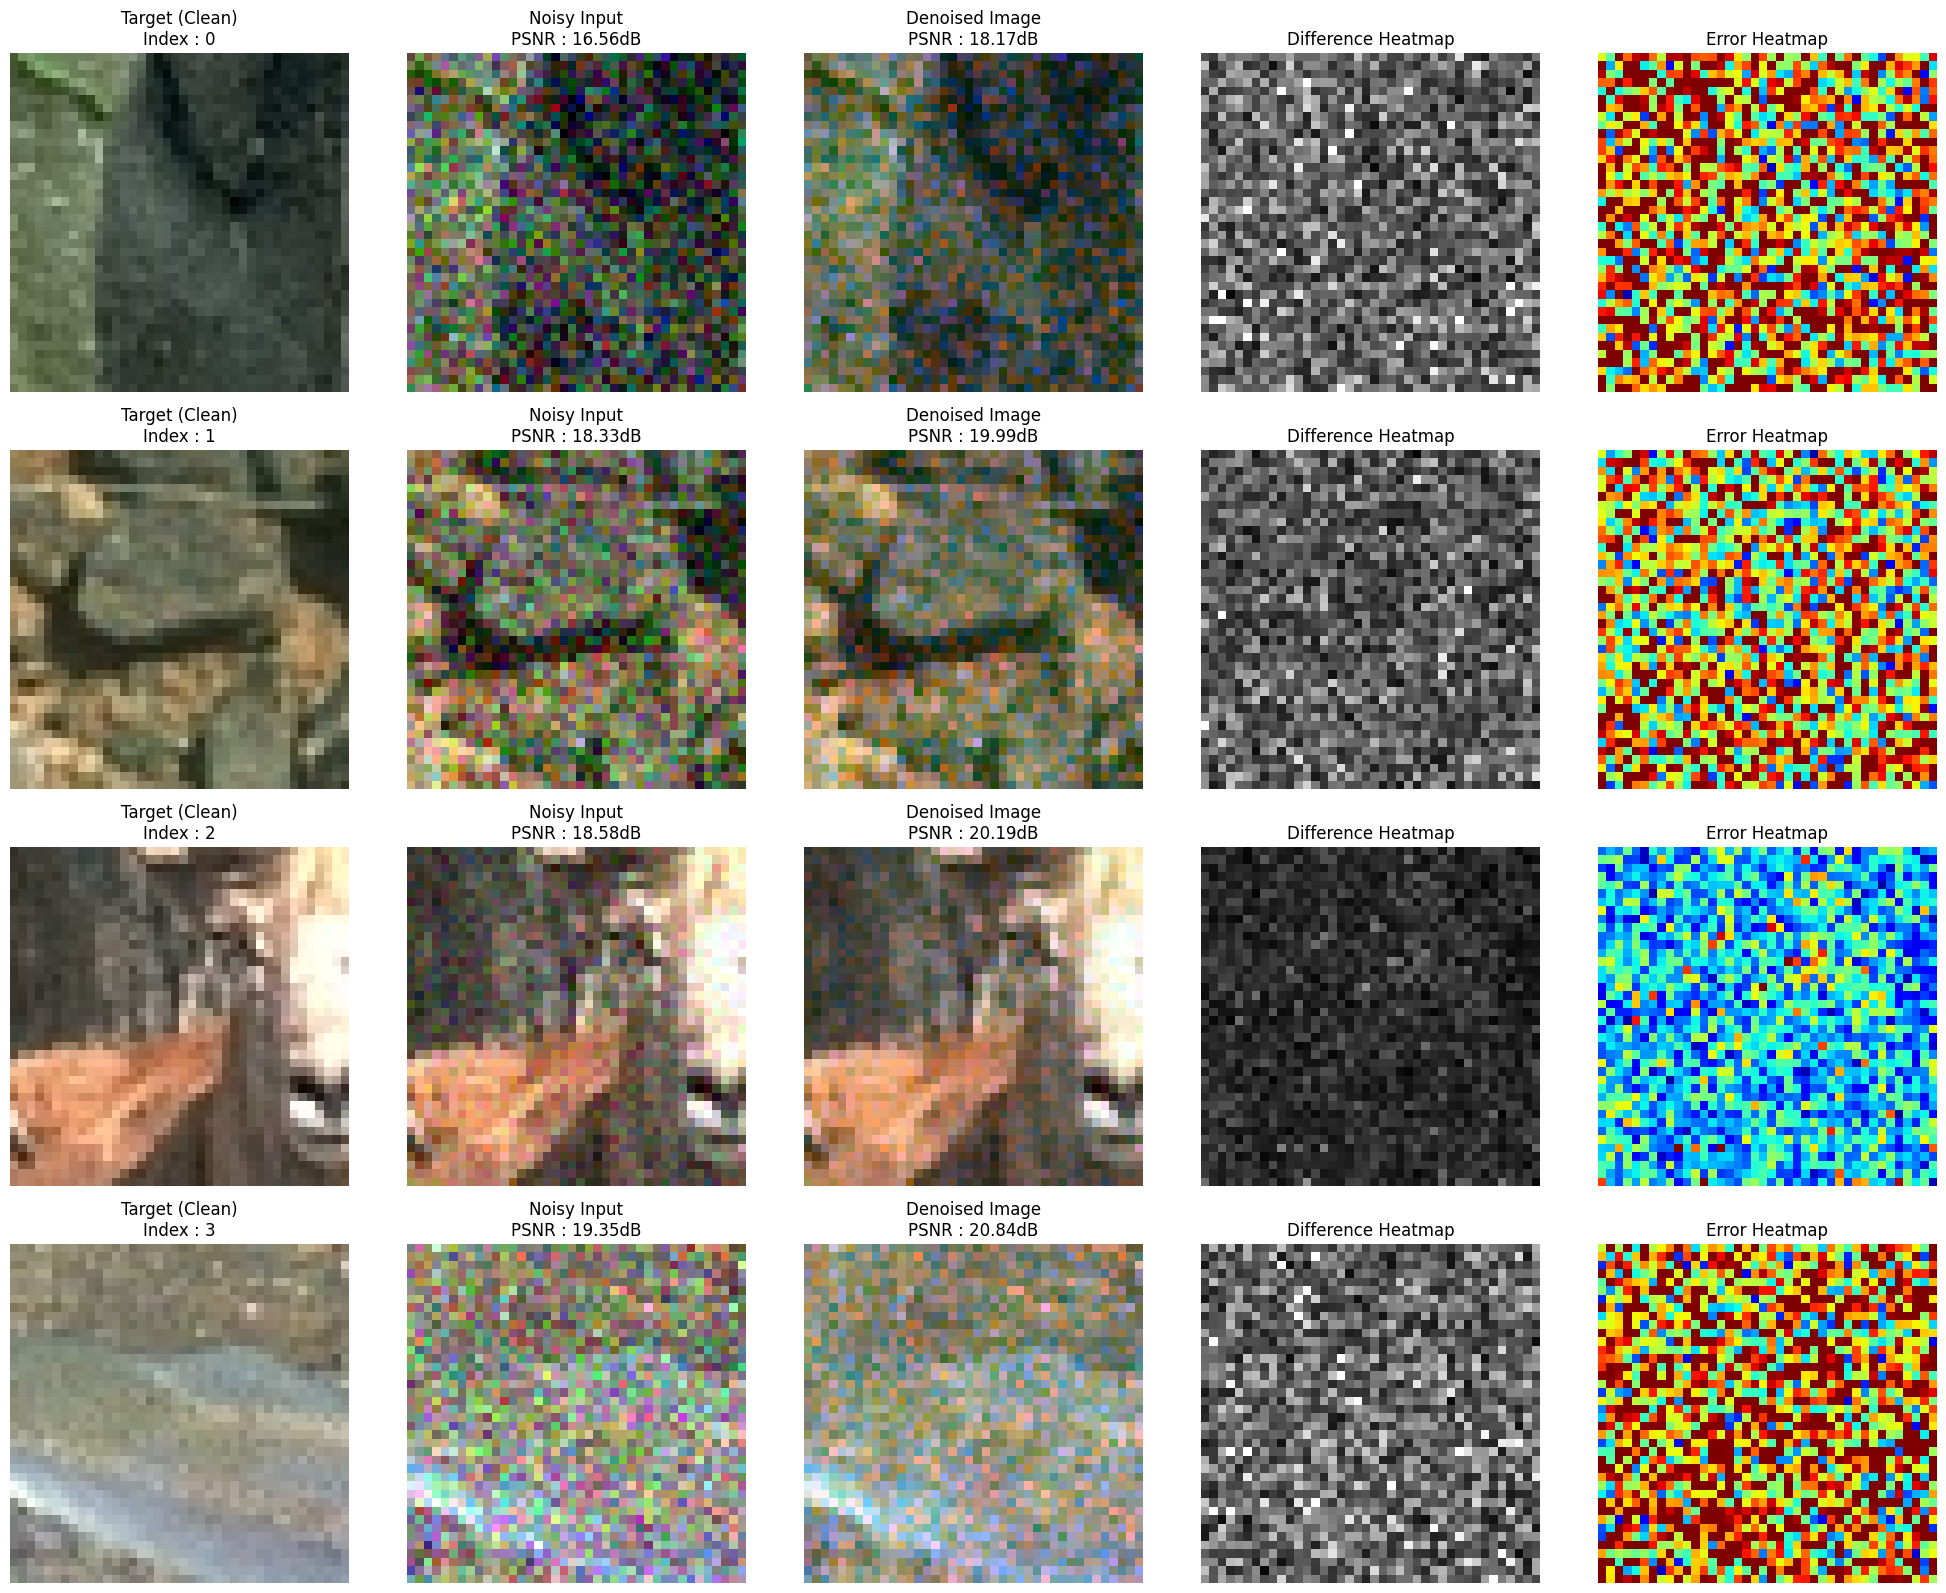

In [94]:
def worst_case(model, val_loader, num_worst=5):
    model.eval()

    all_results = []

    with torch.no_grad():
        for i, (inputs, targets, _) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            denoised_img = torch.clamp(inputs - outputs, 0.0, 1.0)

            PSNR = calculate_PSNR(denoised_img, targets).item()

            all_results.append({
                'index' : i,
                'PSNR' : PSNR,
                'inputs' : inputs.cpu(),
                'targets' : targets.cpu(),
                'denoised_img' : denoised_img.cpu()
            })

    # Sort results by PSNR in ascending order (lower PSNR means worse image quality)
    all_results.sort(key=lambda x: x['PSNR'])
    worst_cases = all_results[:num_worst]

    plt.figure(figsize=(20, 4*num_worst)) # Adjust figure width for 5 subplots
    for i, item in enumerate(worst_cases):
        clean = item['targets'][0].permute(1, 2, 0).numpy()
        noisy = item['inputs'][0].permute(1, 2, 0).numpy() # Get the noisy input image
        denoised = item['denoised_img'][0].permute(1, 2, 0).numpy()
        diff = np.abs(clean-denoised)
        diff_heatmap = np.mean(diff, axis=2)

        # Subplot for Clean Image
        plt.subplot(num_worst, 5, i*5 + 1)
        plt.imshow(clean)
        plt.title(f"Target (Clean)\nIndex : {item['index']}")
        plt.axis('off')

        # Subplot for Noisy Input Image
        psnr_noisy = calculate_PSNR(item['inputs'].squeeze(), item['targets'].squeeze()).item()
        plt.subplot(num_worst, 5, i*5 + 2)
        plt.imshow(noisy)
        plt.title(f"Noisy Input\nPSNR : {psnr_noisy:.2f}dB")
        plt.axis('off')

        # Subplot for Denoised Image
        plt.subplot(num_worst, 5, i*5 + 3)
        plt.imshow(denoised)
        plt.title(f"Denoised Image\nPSNR : {item['PSNR']:.2f}dB")
        plt.axis('off')


        # Subplot for Difference Heatmap
        plt.subplot(num_worst, 5, i*5 + 4)
        plt.imshow(diff_heatmap, cmap='gray', vmin=0, vmax=0.2)
        plt.title("Difference Heatmap")
        plt.axis('off')

        # Subplot for Error Heatmap
        plt.subplot(num_worst, 5, i*5 + 5)
        plt.imshow(diff_heatmap, cmap='jet', vmin=0, vmax=0.1)
        plt.title("Error Heatmap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

worst_case(model, val_loader, num_worst=5)

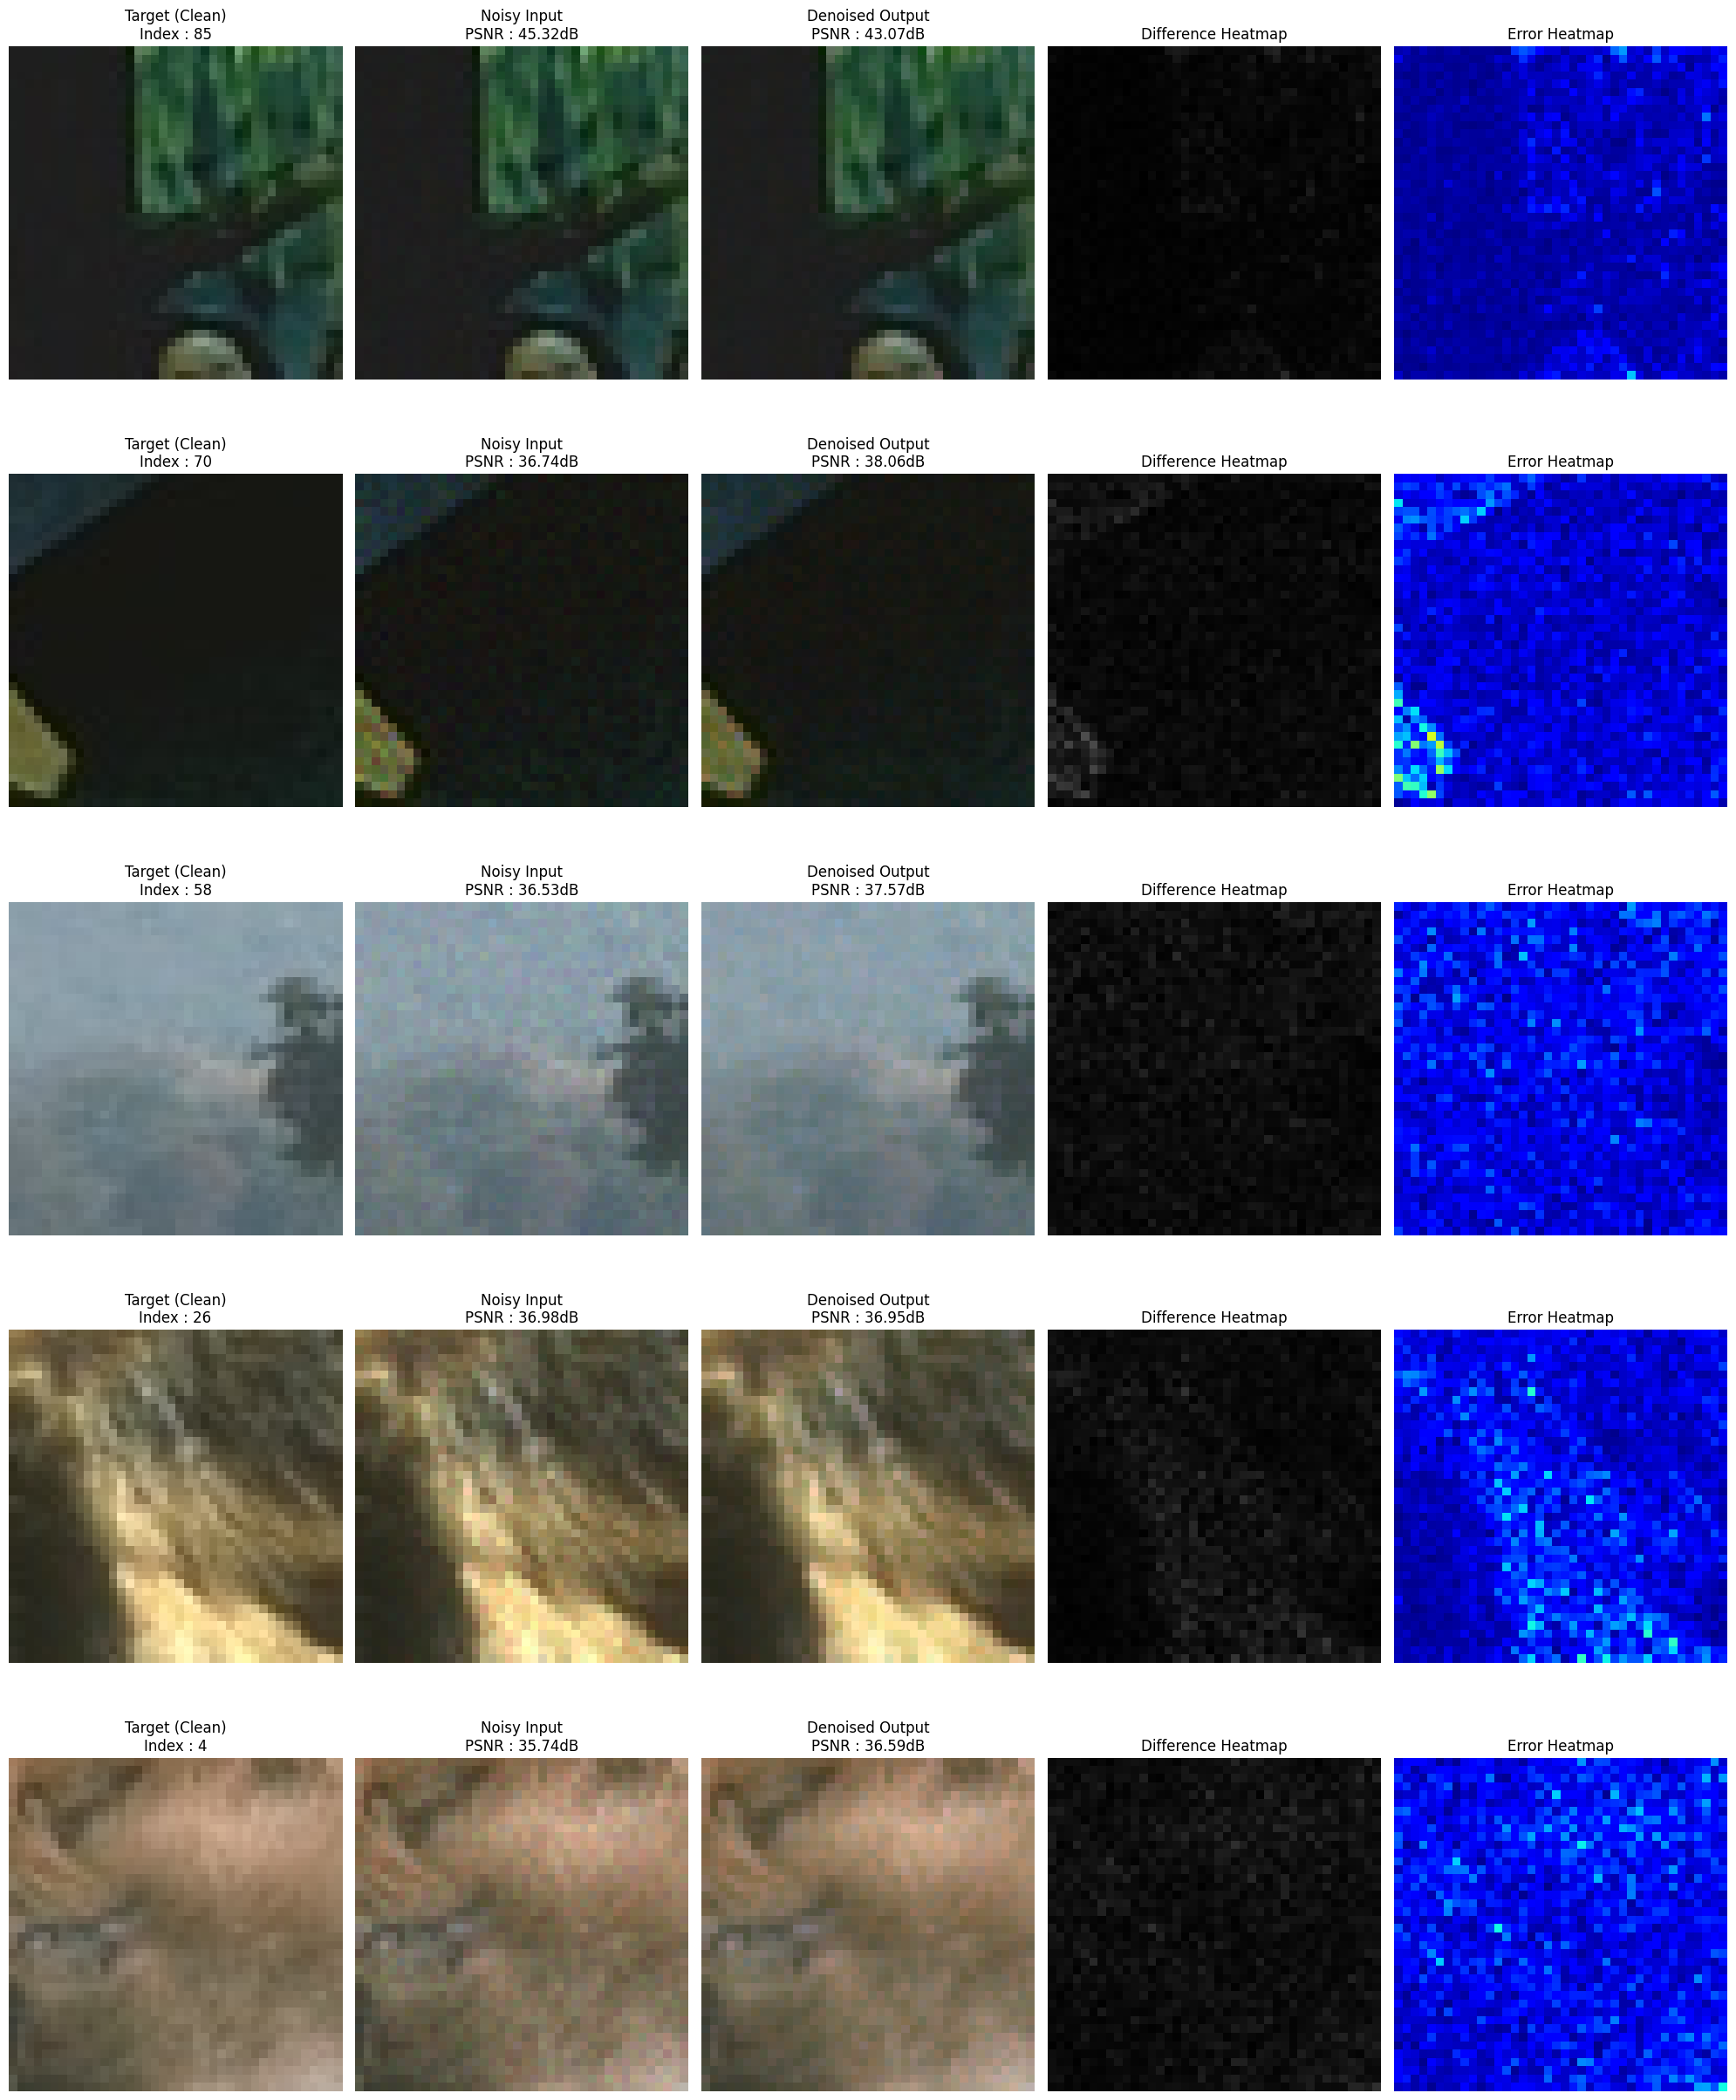

In [96]:
def best_case(model, val_loader, num_best=5, mode='worst'):
    model.eval()
    all_results = []

    with torch.no_grad():
        global_index = 0
        for inputs, targets, _ in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            denoised = torch.clamp(inputs - outputs, 0.0, 1.0)

            # 배치 내의 각 이미지에 대해 반복
            for b in range(inputs.size(0)):
                # 단일 이미지에 대한 PSNR 계산
                PSNR = calculate_PSNR(
                    denoised[b], targets[b]
                ).item()

                all_results.append({
                    'index' : global_index,
                    'PSNR' : PSNR,
                    'inputs' : inputs[b].cpu(),       # Shape: (C, H, W)
                    'targets' : targets[b].cpu(),
                    'denoised_img' : denoised[b].cpu()
                })
                global_index += 1

    reverse = True if mode == 'best' else False
    all_results.sort(key=lambda x: x['PSNR'], reverse=reverse)

    selected_cases = all_results[:num_best]

    plt.figure(figsize=(20, 5 * num_best))

    for i, item in enumerate(selected_cases):
        # 1. 텐서 차원 변환: (C, H, W) -> (H, W, C)
        clean = item['targets'].permute(1, 2, 0).numpy()
        noisy = item['inputs'].permute(1, 2, 0).numpy()
        denoised = item['denoised_img'].permute(1, 2, 0).numpy()
        diff = np.abs(clean - denoised)
        diff_heatmap = np.mean(diff, axis=2) # (H, W, 3) -> (H, W)로 변환

        plt.subplot(num_best, 5, i*5 + 1)
        plt.imshow(clean)
        plt.title(f"Target (Clean)\nIndex : {item['index']}")
        plt.axis('off')

        psnr_noisy = calculate_PSNR(item['inputs'], item['targets']).item()
        plt.subplot(num_best, 5, i*5 + 2)
        plt.imshow(noisy)
        plt.title(f"Noisy Input\nPSNR : {psnr_noisy:.2f}dB")
        plt.axis('off')

        plt.subplot(num_best, 5, i*5 + 3)
        plt.imshow(denoised)
        plt.title(f"Denoised Output\nPSNR : {item['PSNR']:.2f}dB")
        plt.axis('off')

        plt.subplot(num_best, 5, i*5 + 4)
        plt.imshow(diff_heatmap, cmap='gray', vmin=0, vmax=0.2)
        plt.title("Difference Heatmap")
        plt.axis('off')

        plt.subplot(num_best, 5, i*5 + 5)
        plt.imshow(diff_heatmap, cmap='jet', vmin=0, vmax=0.1)
        plt.title("Error Heatmap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

best_case(model, val_loader, num_best=5, mode='best')